total rows:  302
training rows:  211
testing rows:  91
Coeficientes[0] 0.0
Coeficientes[1] 96.38796528458315
total rows after insertion:  302
training rows after insertion:  211
testing rows after insertion:  174
TERMINOS:  [0.99036615, 0.27884825]
[0.99036615, 0.27884825]
lambda:  0.007
alfa:  0.001
time:  14.1080002784729
true,predict
error final:  102.8996722517776


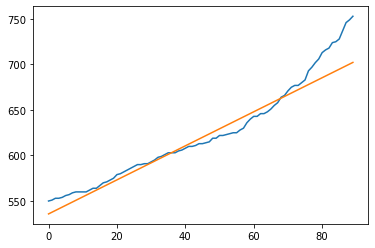

In [6]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from math import e, floor, ceil
from datetime import datetime
from time import time
from sklearn import linear_model

p: int = 2 # grado del polinomio de nuestro modelo de regresión no lineal

DATE = 0; CONFIRMED = 1; DEATHS = 2;
REGION_ORIG = 1; DATE = 2; 

filename = 'covid_cajamarca.csv'
y_training_ds = []
x_training_ds = []
x_testing_ds = []
y_testing_ds = []

n: int = -1
m: int = -1
q: int = -1

with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    # n = len(list(csv_reader))
    n = 302
    training_rows = floor(n*0.7)
    m = training_rows
    testing_rows = ceil(n*0.3)
    q = testing_rows
    print('total rows: ', n)
    print('training rows: ', training_rows)
    print('testing rows: ', testing_rows)
    idx: int = 0
    offset: int = datetime.strptime("01/01/2020", "%m/%d/%Y").timestamp()

    for row in csv_reader:
        if idx != 0:
          marca_de_tiempo: int = datetime.strptime(str(row[0]), "%m/%d/%Y").timestamp()
          nueva_marca_de_tiempo: float = (marca_de_tiempo - offset)/(3600.0 * 24.0 * 30.0)
          # print(nueva_marca_de_tiempo)
          new_x = [1, float(nueva_marca_de_tiempo)]
          new_y = float(row[DEATHS])
          if idx <= training_rows:
            #print('training row')
            x_training_ds.append(new_x)
            y_training_ds.append(new_y)
          else:
            #print('testing row')
            x_testing_ds.append(new_x)
            y_testing_ds.append(new_y)
        idx += 1

reg = linear_model.LinearRegression()
reg.fit(x_training_ds, y_training_ds)

print('Coeficientes[0]', reg.coef_[0])
print('Coeficientes[1]', reg.coef_[1])

print('total rows after insertion: ', n)
print('training rows after insertion: ', len(x_training_ds))
print('testing rows after insertion: ', len(x_testing_ds))

# w = np.random.rand(p)
w = [0.99036615, 0.27884825]
print("TERMINOS: ", w)
# landa = 0.2
# alfa = 0.0015
landa = 0.007
alfa = 0.001
gamma = 0.9
v = [0] * p
print(w)
# hipótesis
def h(w, x, j):
  # w: parametros
  # x: vector de caracteristicas
  # return: valor que predice el modelo 'h' para el j-esimo data point 
  return np.sum([w[i]*(x[j][i]**i) for i in range(p)]) 
  
# true = y_ds
# pred = h(x_training_ds)
def mse(true, h):
  return np.sum([(true[i] - h(w, x_training_ds, i))**2 for i in range(m)])/(2*m)

# true = y_ds
# pred = h(x_training_ds)
def mae(true, h):
  return np.sum([np.abs(true[i] - h(w, x_training_ds, i)) for i in range(m)])/m


def derivada_l1(true, h, l, w, j, x):
  term1 = np.sum([((true[i]-h(w, x, i)) / (np.abs(true[i]-h(w, x, i))))*(-x[i][j]**j) for i in range(m)])
  return term1

def derivada_l2(true, h, l, w, j, x):
  term1 = np.sum([ (true[i] - h(w, x, i))*(-x[i][j]**j) for i in range(m) ])/m
  return term1


def derivada_l2_regularizada(true, h, l, w, j, x):
  term1 = np.sum([ (true[i] - h(w, x, i))*(-x[i][j]**j) for i in range(m) ])/m
  term2 = l*2*w[j]
  return term1 + term2

def derivada_l1_regularizada(true, h, l, w, j, x):
  term1 = np.sum([((true[i]-h(w, x, i)) / (np.abs(true[i]-h(w, x, i))))*(-x[i][j]**j) for i in range(m)])
  return term1 + (l*(w[j]/np.abs(w[j])))

unidades = []
errores = []

def test():
  k = 1
  while (k < 1500):
    unidades.append(k)
    grads = [derivada_l1_regularizada(y_training_ds, h, landa, w, j, x_training_ds) for j in range(p)]
    for i in range(p):
      w[i] = w[i] - alfa*grads[i]
    err = mae(y_training_ds, h)
    errores.append(err)
    #print(err)
    k += 1


start_time = time()
test()
elapsed_time = time() - start_time

print('lambda: ', landa)
print('alfa: ', alfa)
print('time: ', elapsed_time)
# print(unidades)
# print(errores)
# plt.plot(unidades, errores)


verdaderas = []
predicciones = []
unidades2 = []
print('true,predict')

# NOTE: descomentar lo de abajo para probar el error con la regresion de sklearn
# w[0] = reg.coef_[0]
# w[1] = reg.coef_[1]

for i in range(q-1):
    unidades2.append(i)
    row = x_testing_ds[i]
    true = y_testing_ds[i]
    verdaderas.append(true)
    predicciones.append(h(w, x_testing_ds, i))
    # print(true,",",h(w, x_testing_ds, i))

  # w: [0.30685797 0.98797992]
  # l: 0.002
  # a: 0.05
  # 10 000 epocas mejoró

plt.plot(unidades2, verdaderas)
plt.plot(unidades2, predicciones)
print('error final: ', mae(y_training_ds, h))

